In [16]:
import torch, torchvision
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from oil.utils import to_var_gpu
from oil.cnnTrainer import CnnTrainer
from oil.datasets import CIFAR10, C10augLayers
from oil.networkparts import layer13
from oil.schedules import cosLr, sigmoidConsRamp
from oil.calibration import getLogitsAndLabels, get_logit_mean_std, max_logit_calib_rule, get_temperature, evaluate_ECE
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## CNN Configuration

In [2]:
savedir = None
load_path = '/home/maf388/tb-experiments/layer13dev/checkpoints/c.249.ckpt'
total_epochs = 250
opt_constr = lambda params, base_lr: optim.SGD(params, base_lr, .9, weight_decay=1e-4, nesterov=True)
lr_lambda = cosLr(total_epochs, 1)

config = {'base_lr':.1, 'amntLab':1, 'amntDev':5000,
          'lab_BS':50, 'ul_BS':50, 'num_workers':4,
          'lr_lambda':lr_lambda, 'opt_constr':opt_constr,
          'log':False,
          }

fullCNN = nn.Sequential(C10augLayers(),layer13(numClasses=10))
datasets = CIFAR10(aug=False)

Files already downloaded and verified
Files already downloaded and verified


In [3]:
trainer = CnnTrainer(fullCNN, datasets, savedir, load_path, **config)

Creating Train, Dev split         with 45000 Train and 5000 Dev
=> loading checkpoint '/home/maf388/tb-experiments/layer13dev/checkpoints/c.249.ckpt'


In [4]:
trainer.getAccuracy(trainer.dev, trainer.CNN)

0.948

In [6]:
import matplotlib.pyplot as plt
import numpy as np
from oil.utils import to_var_gpu

In [19]:
trainer.CNN.train(False)
devlogits, labels = getLogitsAndLabels(trainer.CNN, trainer.dev)
max_logits, predictions = torch.max(devlogits, 1)
mean, std = get_logit_mean_std(devlogits)
standard_max_logits = (max_logits-mean)/std

p_list = []
for xy in trainer.dev:
    x,y = to_var_gpu(xy)
    p_list.append(F.softmax(trainer.CNN(x),dim=1).detach())
devps = torch.cat(p_list)
max_ps, predictions2 = torch.max(devps,1)
(predictions==predictions2).cpu().data.numpy().all()

True

(array([  5.,  13.,  33.,  68.,  95., 133., 182., 177., 209., 278., 307.,
        366., 364., 390., 364., 346., 366., 316., 259., 225., 172., 114.,
         82.,  58.,  29.,  11.,  22.,   7.,   6.,   3.]),
 array([-2.74410939, -2.54315711, -2.34220483, -2.14125254, -1.94030026,
        -1.73934797, -1.53839569, -1.33744341, -1.13649112, -0.93553884,
        -0.73458656, -0.53363427, -0.33268199, -0.13172971,  0.06922258,
         0.27017486,  0.47112714,  0.67207943,  0.87303171,  1.073984  ,
         1.27493628,  1.47588856,  1.67684085,  1.87779313,  2.07874541,
         2.2796977 ,  2.48064998,  2.68160226,  2.88255455,  3.08350683,
         3.28445911]),
 <a list of 30 Patch objects>)

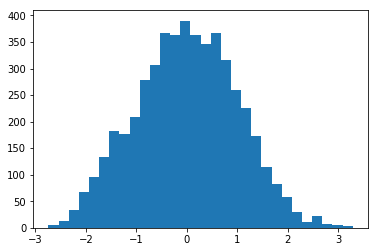

In [22]:
plt.hist(standard_max_logits.cpu().data.numpy(),bins=30)

In [39]:
def rejectLogit(percentile):
    trainer.CNN.train(False)
    i=0
    accSum = 0
    threshold = np.percentile(max_logits.cpu().data.numpy(),percentile)
    for (x, y) in trainer.dev:
        x = to_var_gpu(x, volatile=True)
        y = to_var_gpu(y).cpu().data.numpy()
        max_logit, pred = trainer.CNN(x).max(1)
        max_logit = max_logit.cpu().data.numpy()
        pred = pred.cpu().data.numpy()
        
        accepted = max_logit>threshold
        accSum += (pred[accepted]==y[accepted]).sum()
        i += np.sum(accepted)
    return accSum/i, 1-i/5000

def rejectP(percentile):
    trainer.CNN.train(False)
    i=0
    accSum = 0
    threshold = np.percentile(max_ps.cpu().data.numpy(),percentile)
    for (x, y) in trainer.dev:
        x = to_var_gpu(x, volatile=True)
        y = to_var_gpu(y).cpu().data.numpy()
        max_p, pred = F.softmax(trainer.CNN(x), dim=1).max(1)
        max_p = max_p.cpu().data.numpy()
        pred = pred.cpu().data.numpy()
        
        accepted = max_p>threshold
        accSum += (pred[accepted]==y[accepted]).sum()
        i += np.sum(accepted)
    return accSum/i, 1-i/5000

In [45]:
thresholds = np.linspace(0,25,20)

In [46]:
accsL = np.zeros_like(thresholds)
reject_ratesL = np.zeros_like(thresholds)
accsP = np.zeros_like(thresholds)
reject_ratesP = np.zeros_like(thresholds)

for i, thresh in enumerate(thresholds):
    accsL[i], reject_ratesL[i] = rejectLogit(thresh)
    accsP[i], reject_ratesP[i] = rejectP(thresh)

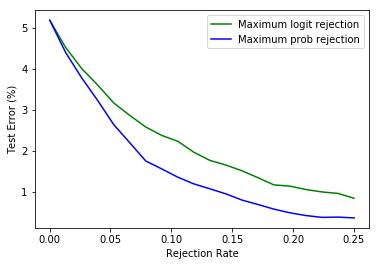

In [49]:
plt.xlabel("Rejection Rate")
plt.ylabel("Test Error (%)")
plt.plot(reject_ratesL, 100*(1-accsL),color='green')
plt.plot(reject_ratesP, 100*(1-accsP),color='blue')
plt.legend(["Maximum logit rejection", "Maximum prob rejection"])

In [38]:
thresholds

array([ 0.  ,  6.25, 12.5 , 18.75, 25.  ])

In [61]:
def stratAcc(threshold, bin_width):
    trainer.CNN.train(False)
    #i=0
    #accSum = 0
    acceptedAccs = []
    for (x, y) in trainer.dev:
        x = to_var_gpu(x, volatile=True)
        y = to_var_gpu(y).cpu().data.numpy()
        max_logit = trainer.CNN(x).max(1)[0].cpu().data.numpy()
        pred = trainer.CNN(x).max(1)[1].cpu().data.numpy()
        accepted = (max_logit>threshold)&(max_logit <= threshold + bin_width)
        if np.any(accepted):
            acceptedAccs.append((pred[accepted]==y[accepted]).astype(np.int64))
    if acceptedAccs != []:
        acceptedAccs = np.concatenate(acceptedAccs).ravel()
    count = len(acceptedAccs)
    if count:
#         print(acceptedAccs)
#         print(acceptedAccs.shape)
        std = acceptedAccs.std()
        acc = acceptedAccs.mean()
        #print(std)
    else:
        std = 0
        acc = 0
    return acc, count, std

In [62]:
thresh2 = np.linspace(2,40,30)
bin_width = thresh2[1]-thresh2[0]
accs2 = np.zeros_like(thresh2)
counts = np.zeros_like(thresh2)
stds = np.zeros_like(thresh2)

In [63]:
for i, thresh in enumerate(thresh2):
    accs2[i], counts[i], stds[i] = stratAcc(thresh, bin_width)

[  0.   7.  26.  84. 157. 218. 318. 347. 445. 526. 624. 685. 686. 762.
 761. 831. 692. 675. 581. 479. 349. 258. 184. 120.  84.  42.  20.  16.
   7.   6.]


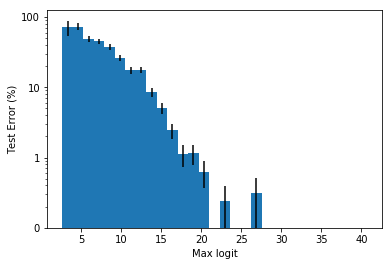

In [79]:
print(counts)
from matplotlib.ticker import ScalarFormatter
fig, ax = plt.subplots()

y = 100*(1-accs2)


ax.bar(thresh2[1:], y[1:], bin_width, yerr=100*stds[1:]/np.sqrt(counts[1:]), bottom=.1)
ax.set_xlabel("Max logit")
ax.set_ylabel("Test Error (%)")
ax.set_yscale('log')
for axis in [ax.xaxis, ax.yaxis]:
    axis.set_major_formatter(ScalarFormatter())
plt.show()

[  0.   7.  26.  84. 157. 218. 318. 347. 445. 526. 624. 685. 686. 762.
 761. 831. 692. 675. 581. 479. 349. 258. 184. 120.  84.  42.  20.  16.
   7.   6.]


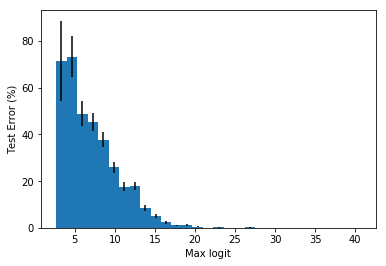

In [80]:
from matplotlib.ticker import ScalarFormatter
fig, ax = plt.subplots()

y = 100*(1-accs2)


ax.bar(thresh2[1:], y[1:], bin_width, yerr=100*stds[1:]/np.sqrt(counts[1:]), bottom=.1)
ax.set_xlabel("Max logit")
ax.set_ylabel("Test Error (%)")
plt.show()

In [124]:
import torch.nn.functional as F
trainer.CNN.train(False)
max_ps = np.zeros(10000)
i=0
for (x, y) in trainer.dev:
    x = to_var_gpu(x, volatile=True)
    bs = x.size()[0]
    max_ps[i:i+bs] = F.softmax(trainer.CNN(x),dim=1).max(1)[0].cpu().data.numpy()
    i += bs

(array([2342.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
         203.,  181.,  167.,  147.,  177.,  153.,  168.,  132.,  132.,
         109.,  122.,  129.,   95.,   83.,   88.,   91.,   85.,   91.,
         100.,  109.,   96.]),
 array([-23.0258503 , -22.26790736, -21.50996443, -20.75202149,
        -19.99407856, -19.23613562, -18.47819269, -17.72024975,
        -16.96230682, -16.20436388, -15.44642095, -14.68847801,
        -13.93053508, -13.17259214, -12.41464921, -11.65670627,
        -10.89876334, -10.1408204 ,  -9.38287747,  -8.62493453,
         -7.8669916 ,  -7.10904866,  -6.35110573,  -5.59316279,
         -4.83521986,  -4.07727693,  -3.31933399,  -2.56139106,
         -1.80344812,  -1.04550519,  -0.28756225]),
 <a list of 30 Patch objects>)

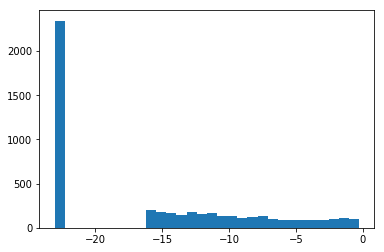

In [77]:
plt.hist(np.log(1-max_ps.cpu().data.numpy()+1e-10),bins=30)

In [54]:
def stratAccP(lower, upper):
    trainer.CNN.train(False)
    #i=0
    #accSum = 0
    acceptedAccs = []
    for (x, y) in trainer.dev:
        x = to_var_gpu(x, volatile=True)
        y = to_var_gpu(y).cpu().data.numpy()
        max_p, pred = F.softmax(trainer.CNN(x),dim=1).max(1)
        max_p = max_p.cpu().data.numpy()
        pred = pred.cpu().data.numpy()
        accepted = (max_p>lower)&(max_p <= upper)
        if np.any(accepted):
            acceptedAccs.append((pred[accepted]==y[accepted]).astype(np.int64))
    if acceptedAccs != []:
        acceptedAccs = np.concatenate(acceptedAccs).ravel()
    count = len(acceptedAccs)
    if count:
#         print(acceptedAccs)
#         print(acceptedAccs.shape)
        std = acceptedAccs.std()
        acc = acceptedAccs.mean()
        #print(std)
    else:
        std = 0
        acc = 0
    return acc, count, std

In [55]:
percentiles = np.linspace(0,100,30)
thresholds = np.percentile(max_ps.cpu().data.numpy(),percentiles)
accs = np.zeros_like(thresholds)
counts = np.zeros_like(thresholds)
stds = np.zeros_like(thresholds)

In [56]:
for i, (lower, upper) in enumerate(zip(thresholds[:-1],thresholds[1:])):
    accs[i], counts[i], stds[i] = stratAccP(lower, upper)

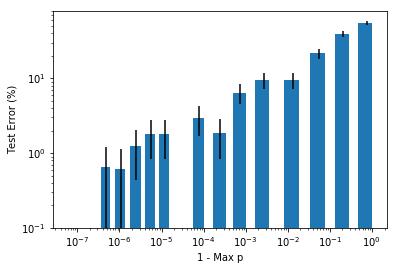

In [72]:
fig, ax = plt.subplots()

y = 100*(1-accs)
mk = counts>0
bin_widths = np.append(thresholds[1:]-thresholds[:-1],.1)
ax.bar(1-thresholds[mk], y[mk], bin_widths[mk], yerr=100*stds[mk]/np.sqrt(counts[mk]), bottom=.1)
ax.set_xlabel("1 - Max p")
ax.set_ylabel("Test Error (%)")
ax.set_yscale('log')
ax.set_xscale('log')
plt.show()

In [81]:
counts[:20]
percentiles[:16]

array([ 0.        ,  3.44827586,  6.89655172, 10.34482759, 13.79310345,
       17.24137931, 20.68965517, 24.13793103, 27.5862069 , 31.03448276,
       34.48275862, 37.93103448, 41.37931034, 44.82758621, 48.27586207,
       51.72413793])

In [132]:
print(counts3.astype(int))

[  10    3   11    5   11   14   15   11   10   19   19   16   20   18
   19   16   15    9   25   24   34   40   29   33   55   65  109  174
 8721    0]


In [117]:
print(counts3.sum())

270349.0
